File: bursting/cell89basal.abf | sweeps: 30 | total length: 645.00 s
     Burst_Number  Start_Time_s  End_Time_s         Type
0               1       76.5200     77.4671  Square Wave
1               2      104.7433    107.4776  Square Wave
2               3      191.0791    193.4927  Square Wave
3               4      207.6007    212.0541  Square Wave
4               5      322.6933    322.8075  Square Wave
..            ...           ...         ...          ...
272           273      632.1943    634.1843    Parabolic
273           274      634.5038    634.7590    Parabolic
274           275      638.2392    638.3164    Parabolic
275           276      638.6217    639.7094    Parabolic
276           277      642.4200    642.5522    Parabolic

[277 rows x 4 columns]


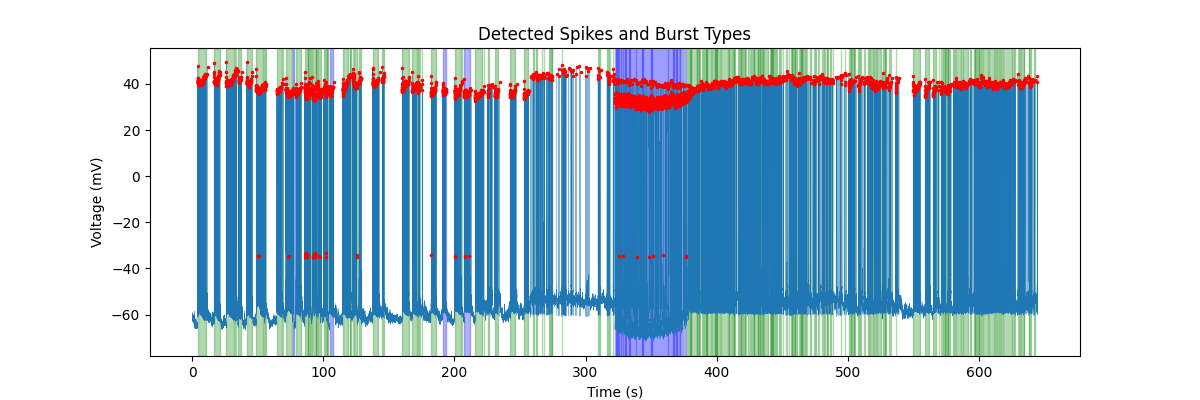

In [1]:
#This part is mostly based on what Serafim shared me about spikes and bursts detection, so there will be a little less explanation than 
#in the 2nd code cell

import pyabf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%matplotlib widget

#Load the entire abf 
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

#Concatenate the sweeps
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
dt = 1.0 / abf.dataRate
time = np.arange(len(signal)) * dt

print(f"File: {file_path} | sweeps: {abf.sweepCount} | total length: {time[-1]:.2f} s") #Basic information, each abf has its own length and sweeps number


#spikes detection
threshold = -35  # mV
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]



#Burst detection
isi = np.diff(spike_times)
burst_threshold = 0.3  # s

bursts = []
current_burst = [spike_times[0]]
for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:
        current_burst.append(spike_times[i])
    else:
        if len(current_burst) > 1:
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))




#Burst classification
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min = np.min(signal[burst_mask])

    #Interburst mean intervals
    prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < burst_start)]) if i > 0 else np.nan
    next_mean = np.mean(signal[(time > burst_end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
    inter_mean = np.nanmean([prev_mean, next_mean])

    if burst_min > inter_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min < inter_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))


#Save information in CSV
burst_list = []

for idx, (start, end) in enumerate(square_wave_bursts):
    burst_list.append([idx+1, start, end, "Square Wave"])
for idx, (start, end) in enumerate(parabolic_bursts):
    burst_list.append([idx+1+len(square_wave_bursts), start, end, "Parabolic"])
for idx, (start, end) in enumerate(other_bursts):
    burst_list.append([idx+1+len(square_wave_bursts)+len(parabolic_bursts), start, end, "Other"])

df_bursts = pd.DataFrame(burst_list, columns=["Burst_Number", "Start_Time_s", "End_Time_s", "Type"])
df_bursts.to_csv("burst_info_cell89.csv", index=False)
print(df_bursts)



#Plotting spikes and bursts
plt.figure(figsize=(12,4))
plt.plot(time, signal, lw=0.2)
plt.plot(spike_times, signal[spike_indices], 'r.', markersize=3)

for start, end in square_wave_bursts:
    plt.axvspan(start, end, color='blue', alpha=0.3)
for start, end in parabolic_bursts:
    plt.axvspan(start, end, color='green', alpha=0.3)
for start, end in other_bursts:
    plt.axvspan(start, end, color='orange', alpha=0.3)

plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Detected Spikes and Burst Types")
plt.show()

Se detectaron 278 bursts
   Burst_Number  Start_Time_s  End_Time_s       Type
0             1        4.1492     10.4632  Parabolic
1             2       16.7984     21.0475  Parabolic
2             3       25.9975     31.7546  Parabolic
3             4       32.2976     32.6686  Parabolic
4             5       33.2434     33.6903  Parabolic
5             6       35.2539     37.2636  Parabolic
6             7       41.4399     45.3242  Parabolic
7             8       48.8635     53.6932  Parabolic
8             9       54.3833     55.0212  Parabolic
9            10       55.5536     56.1263  Parabolic


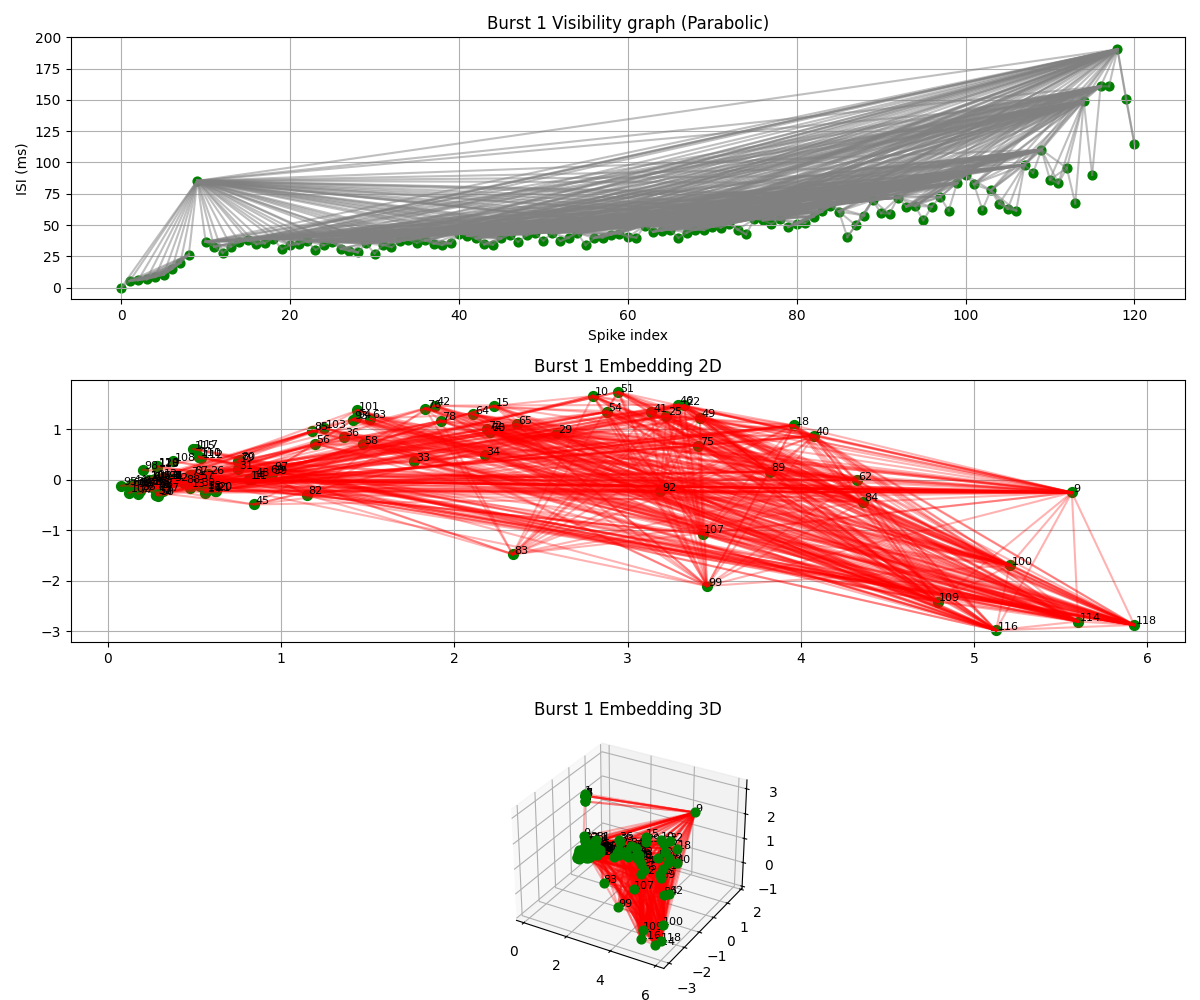

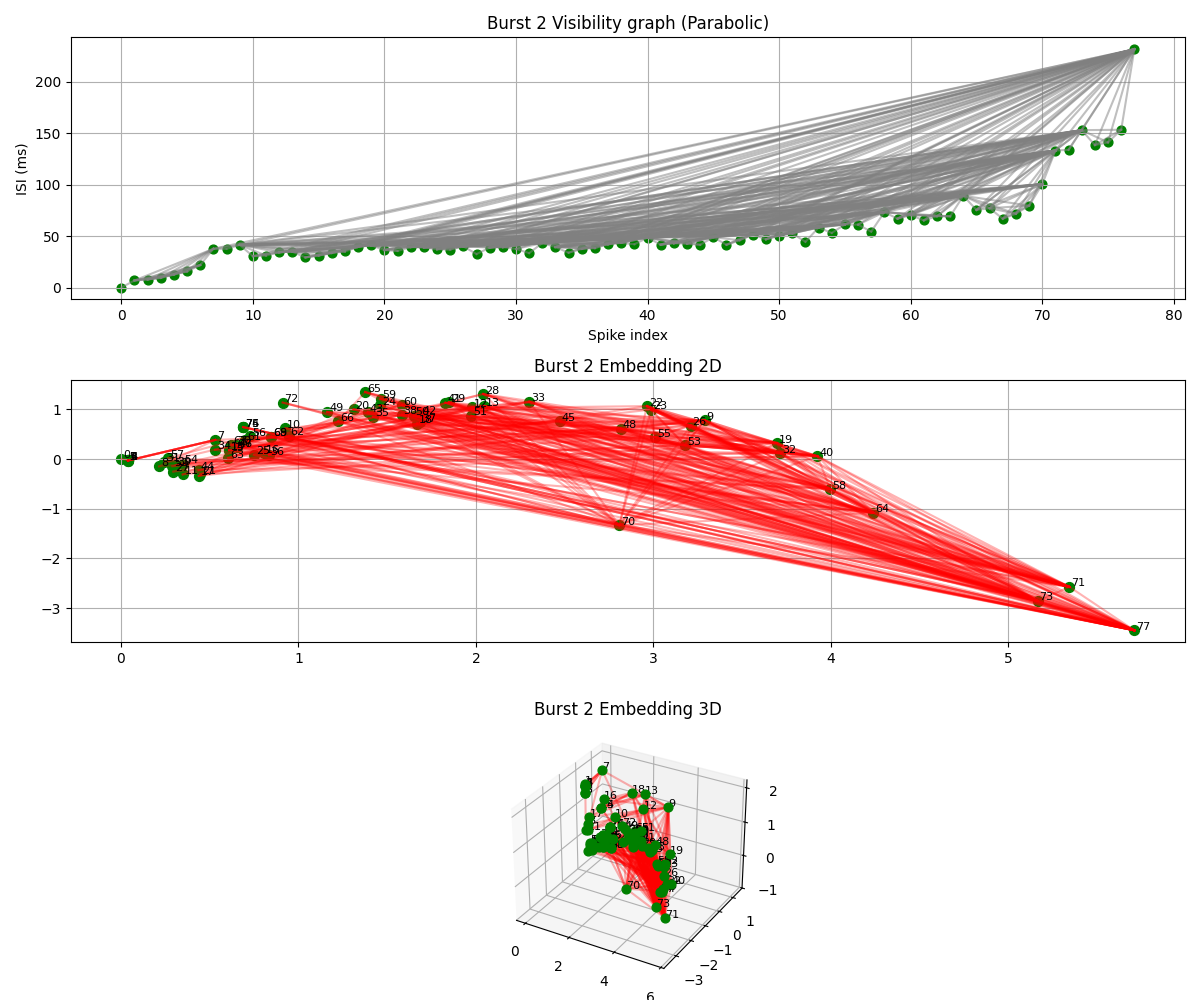

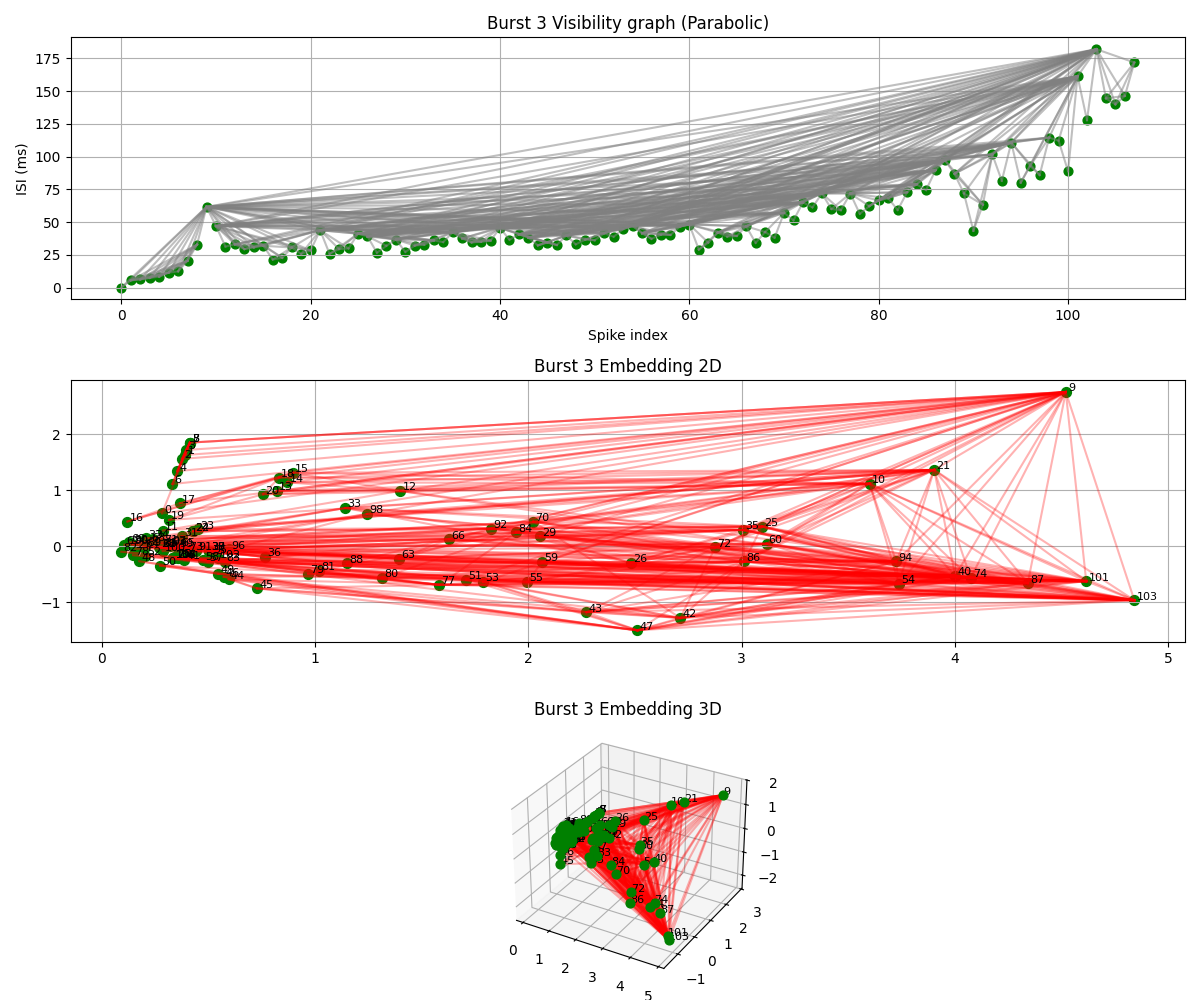

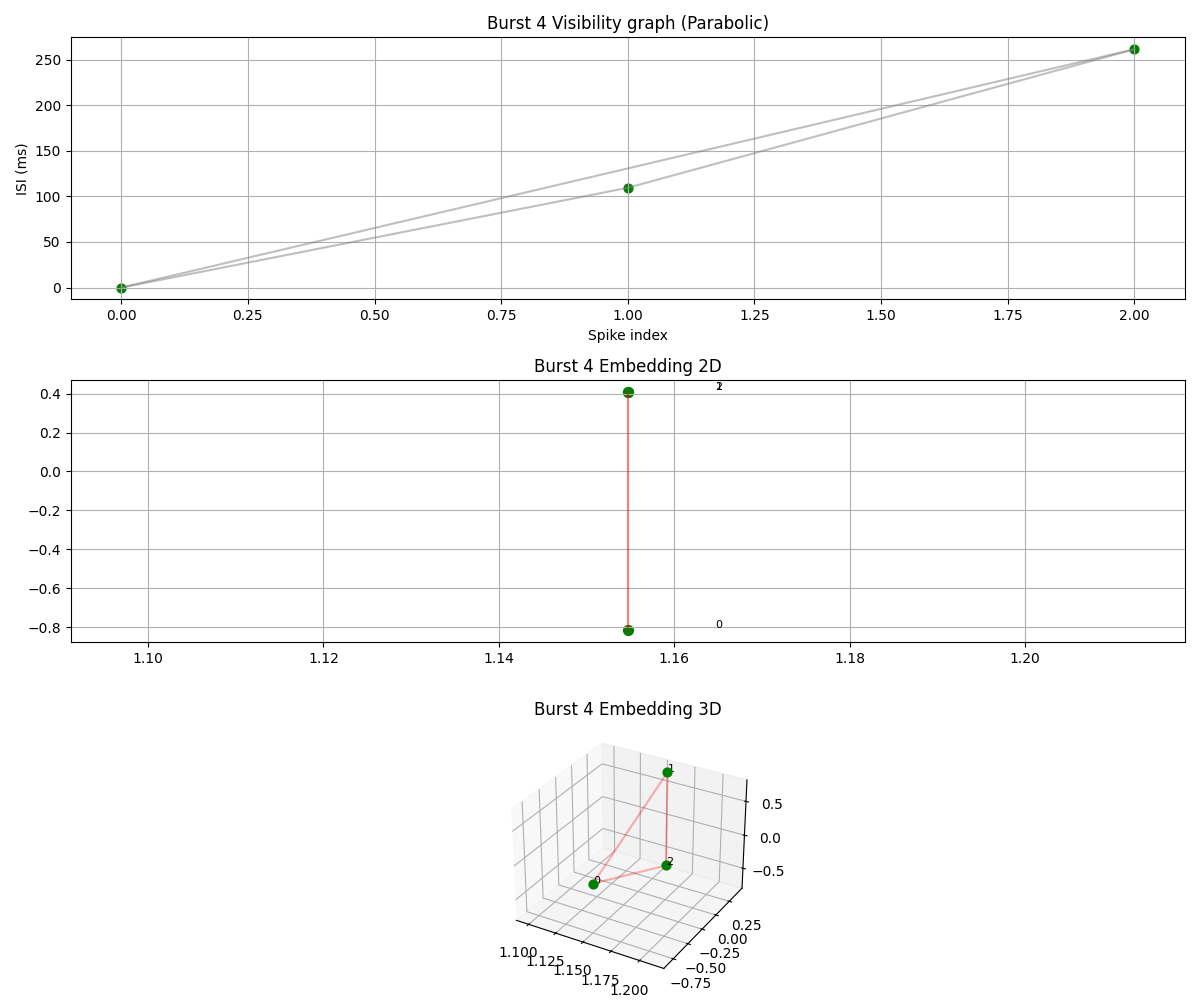

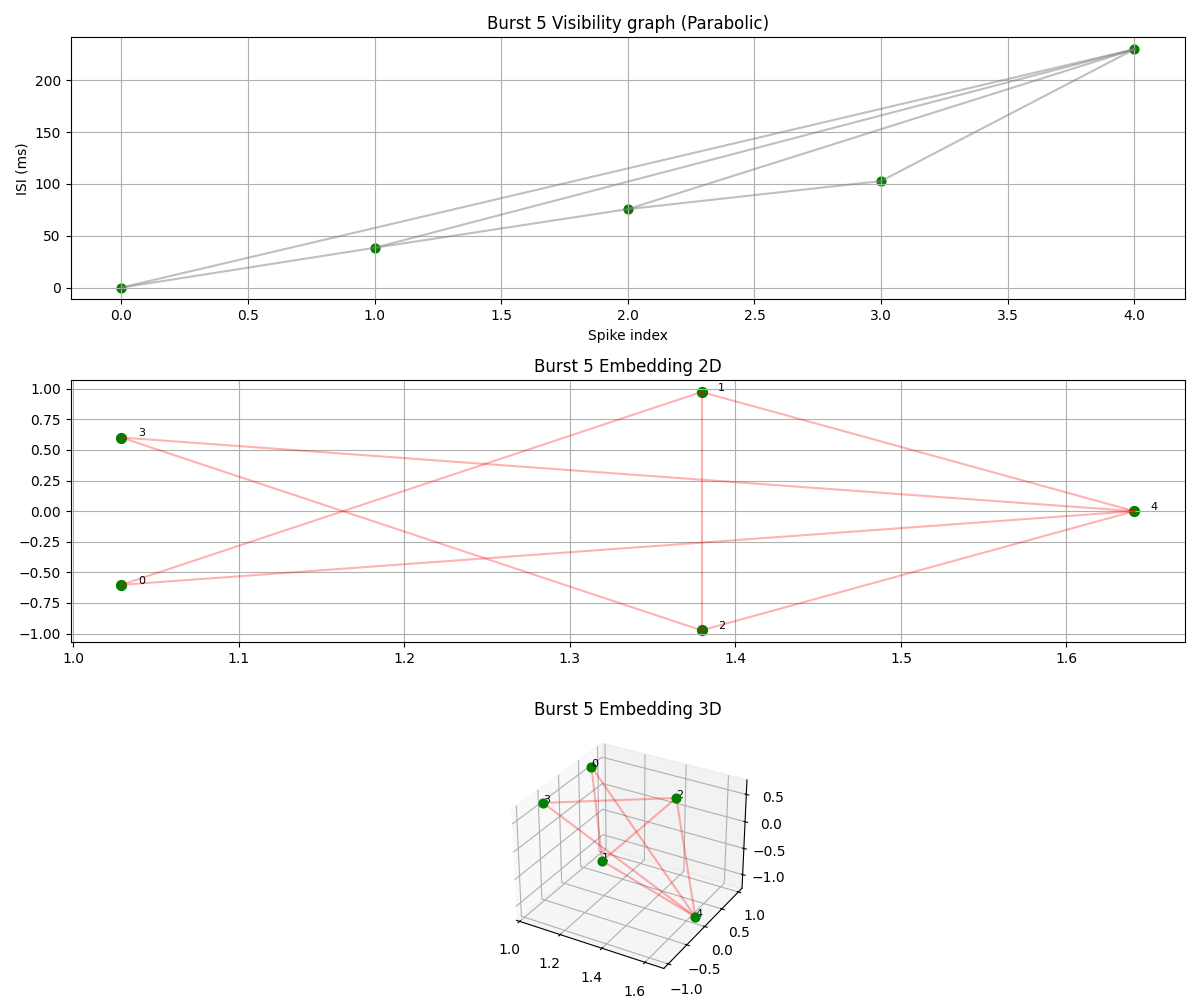

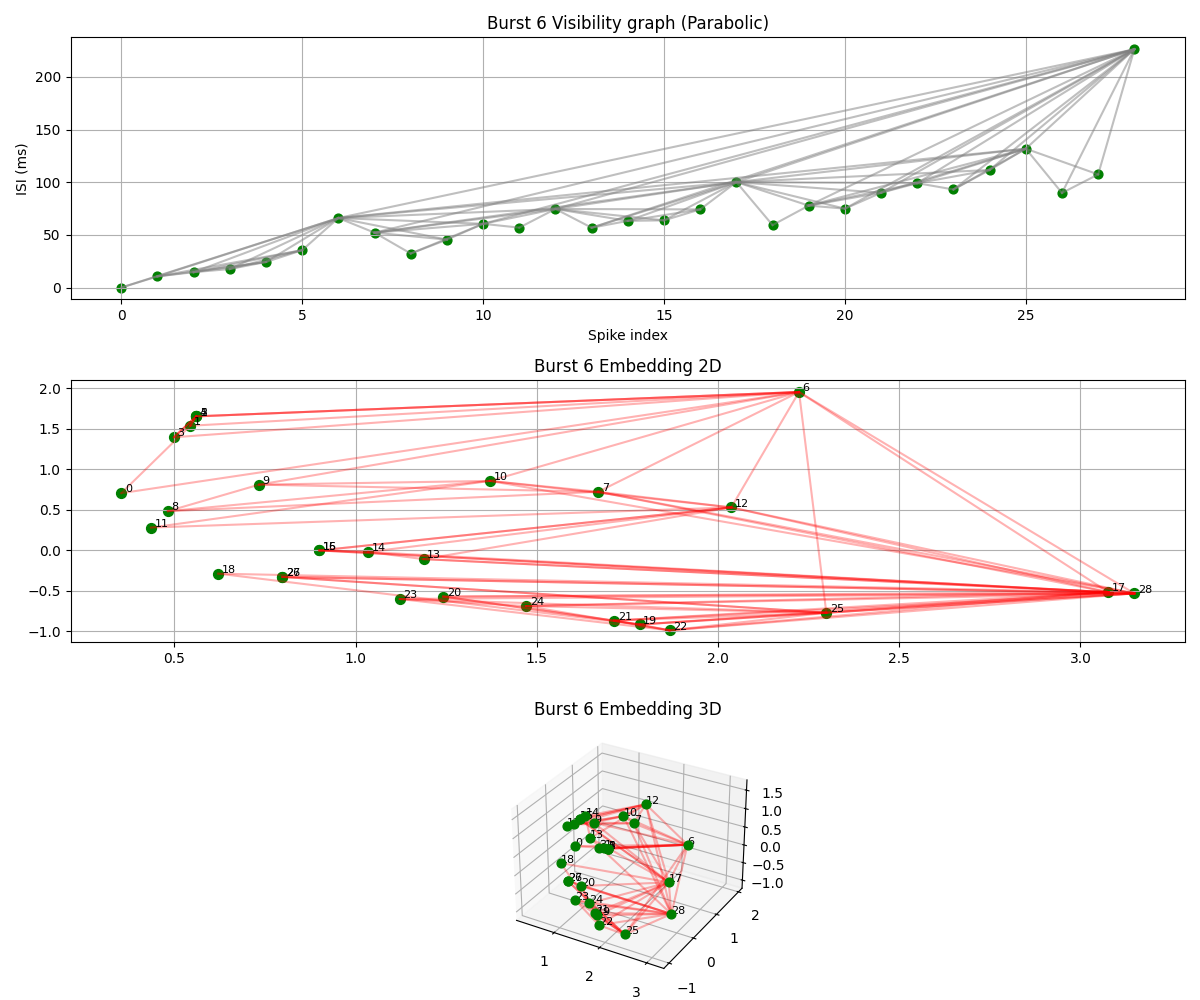

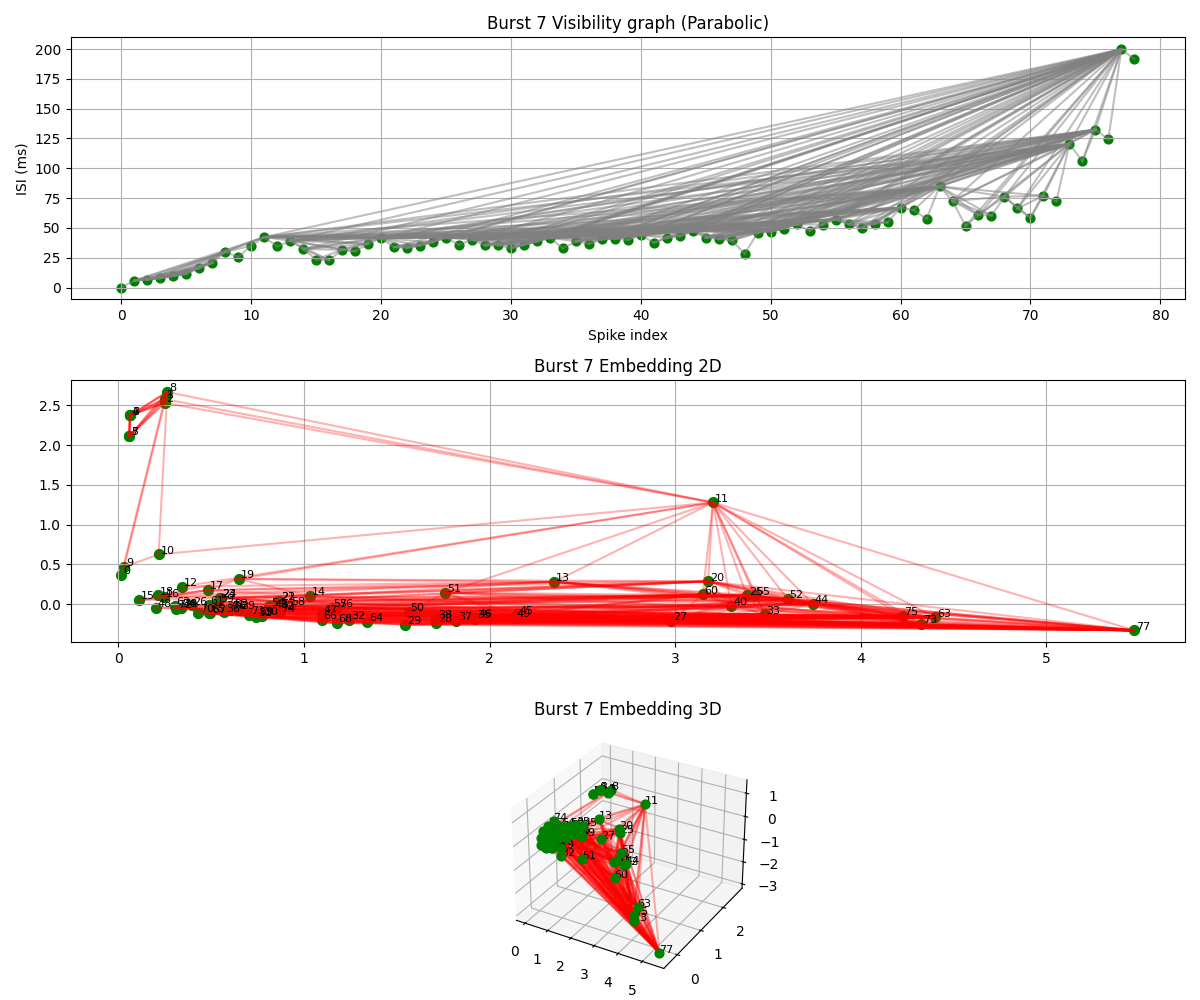

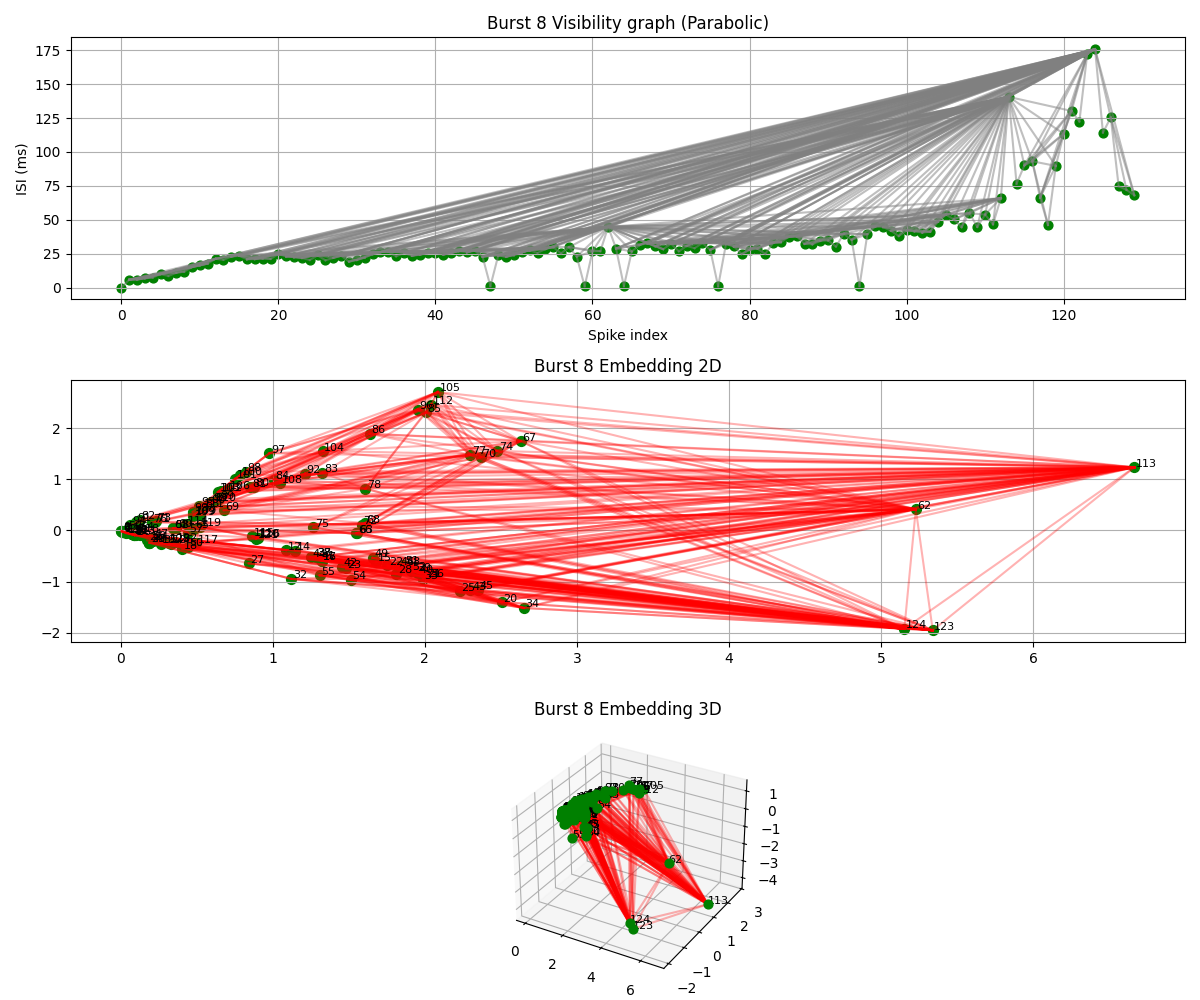

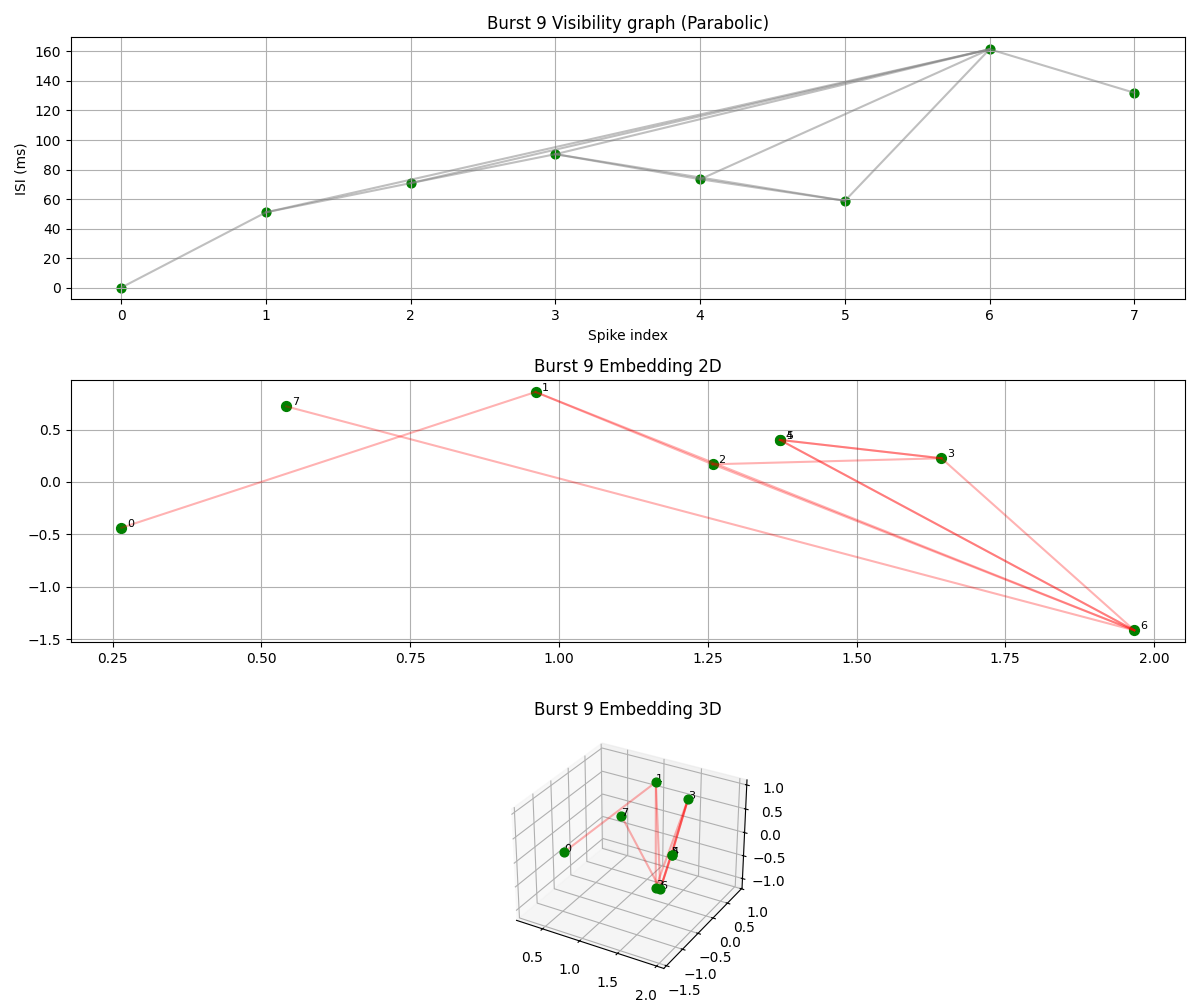

C:\Users\manur\AppData\Local\Temp\ipykernel_17628\3036983786.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,10))


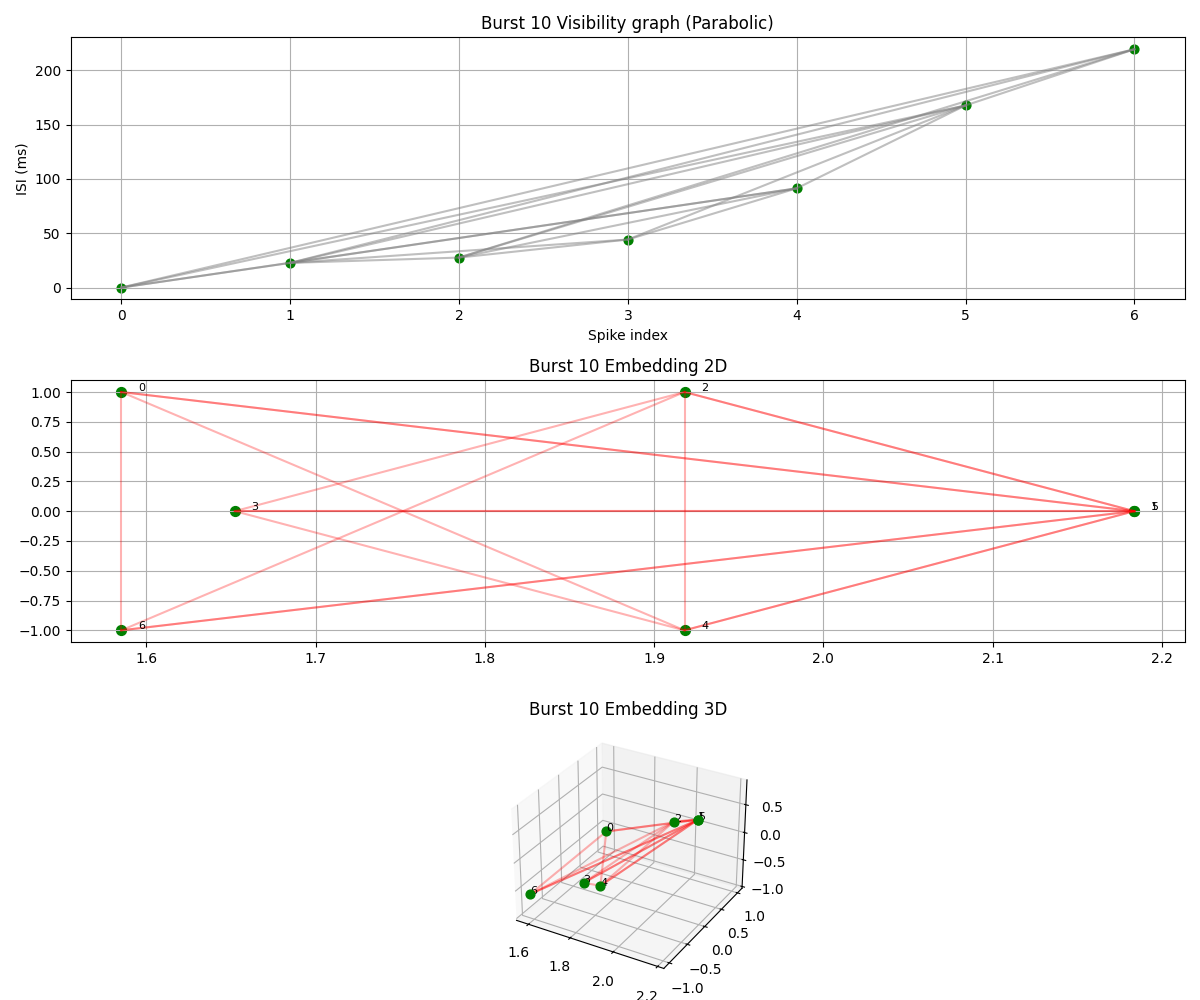

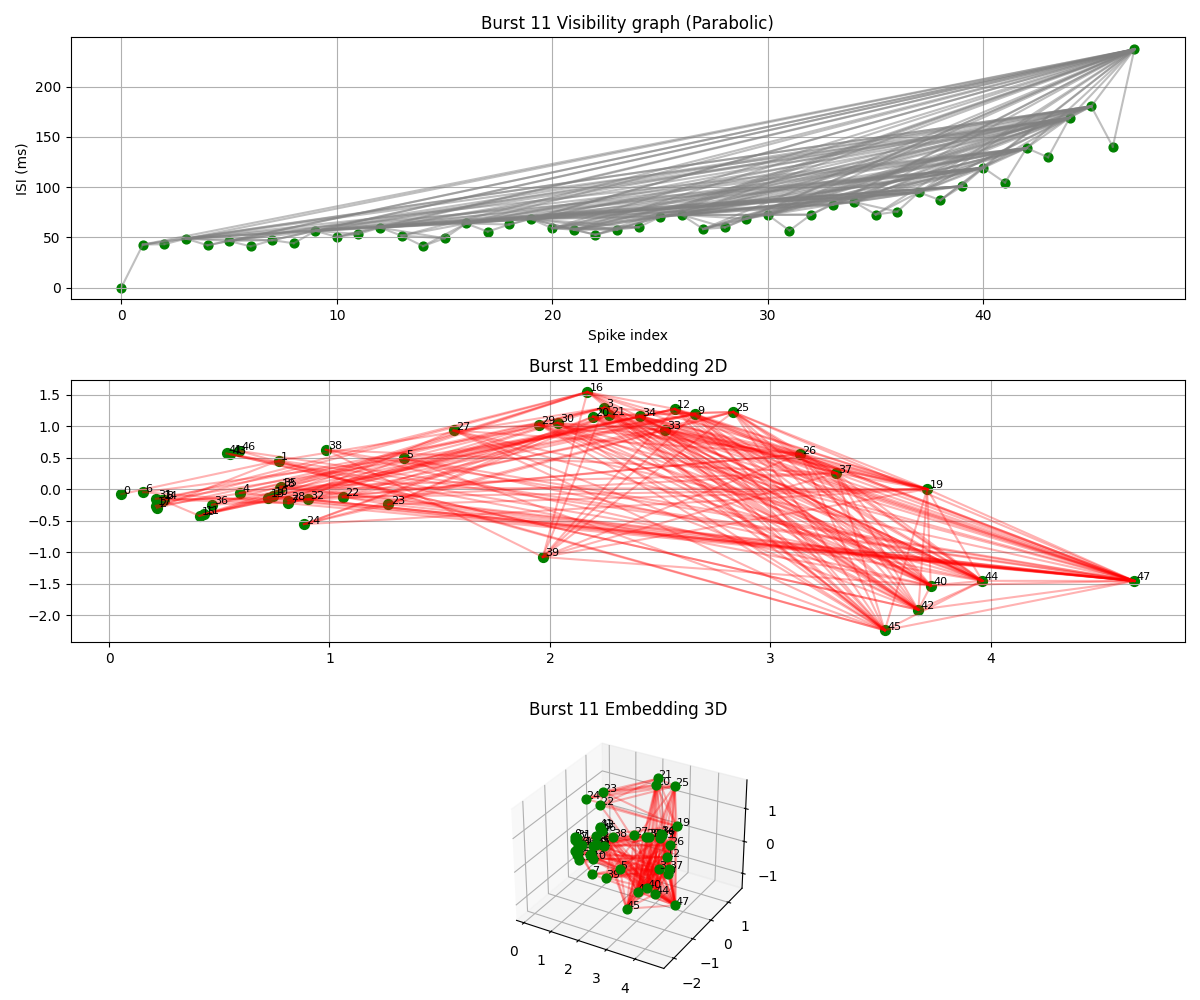

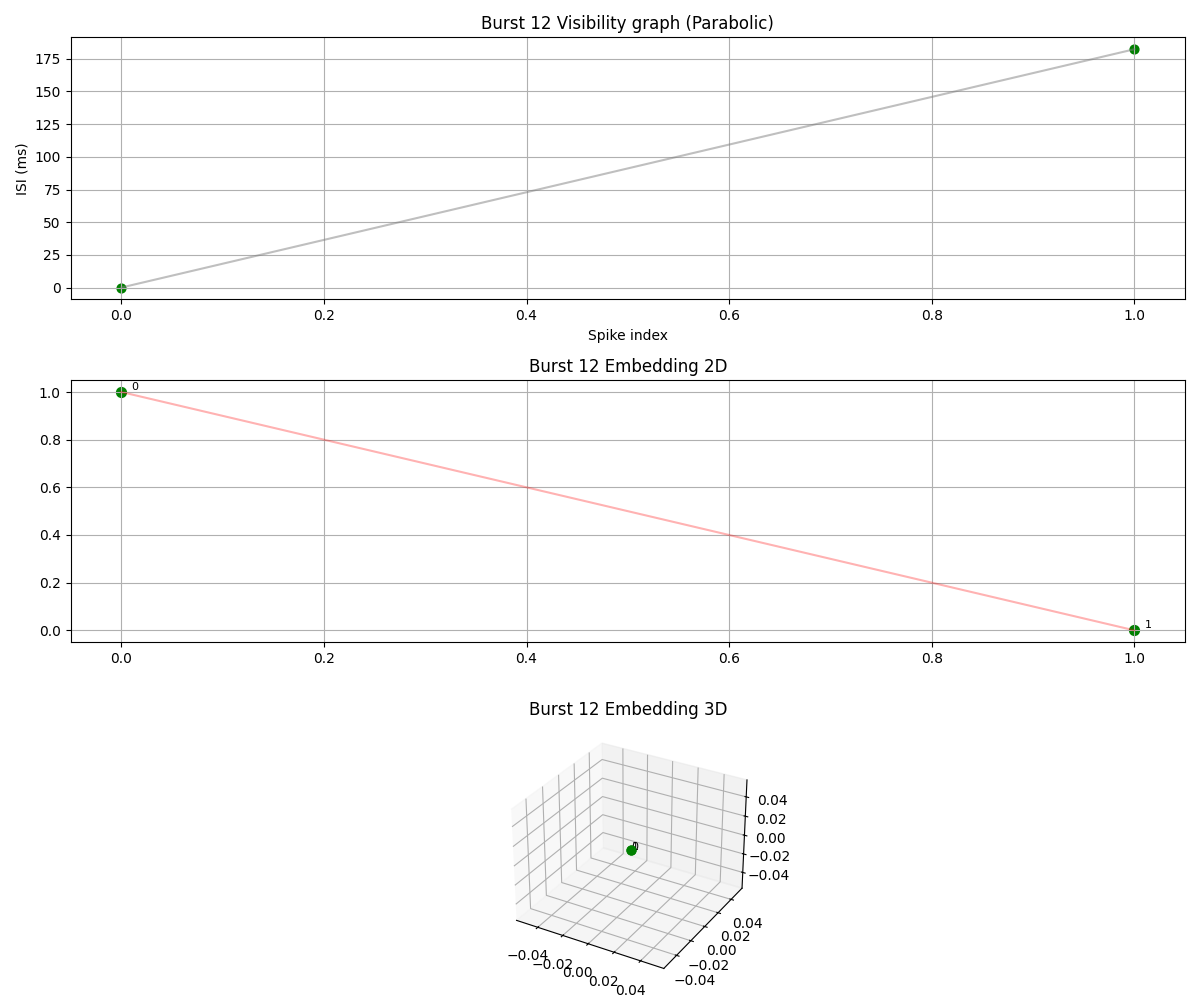

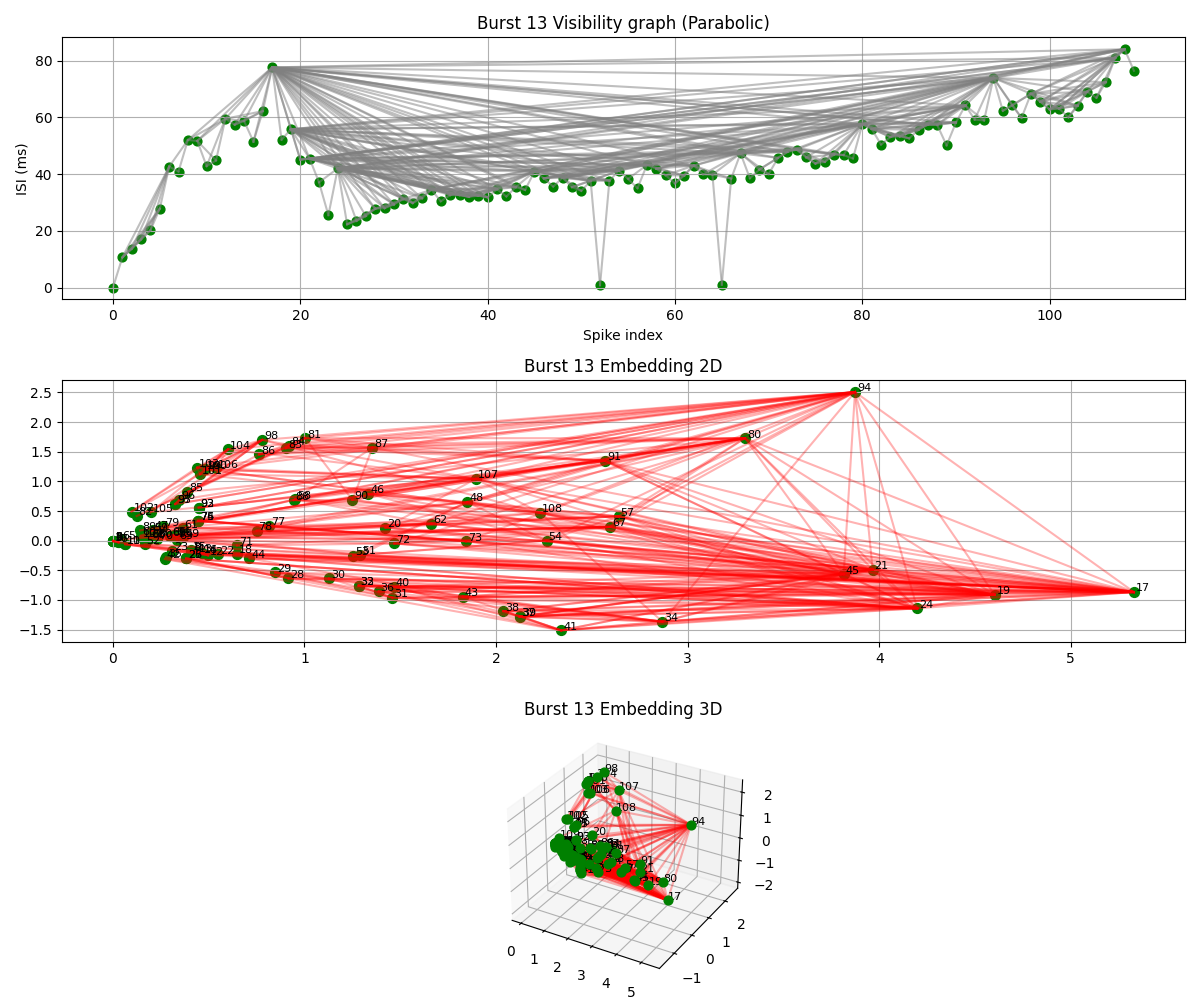

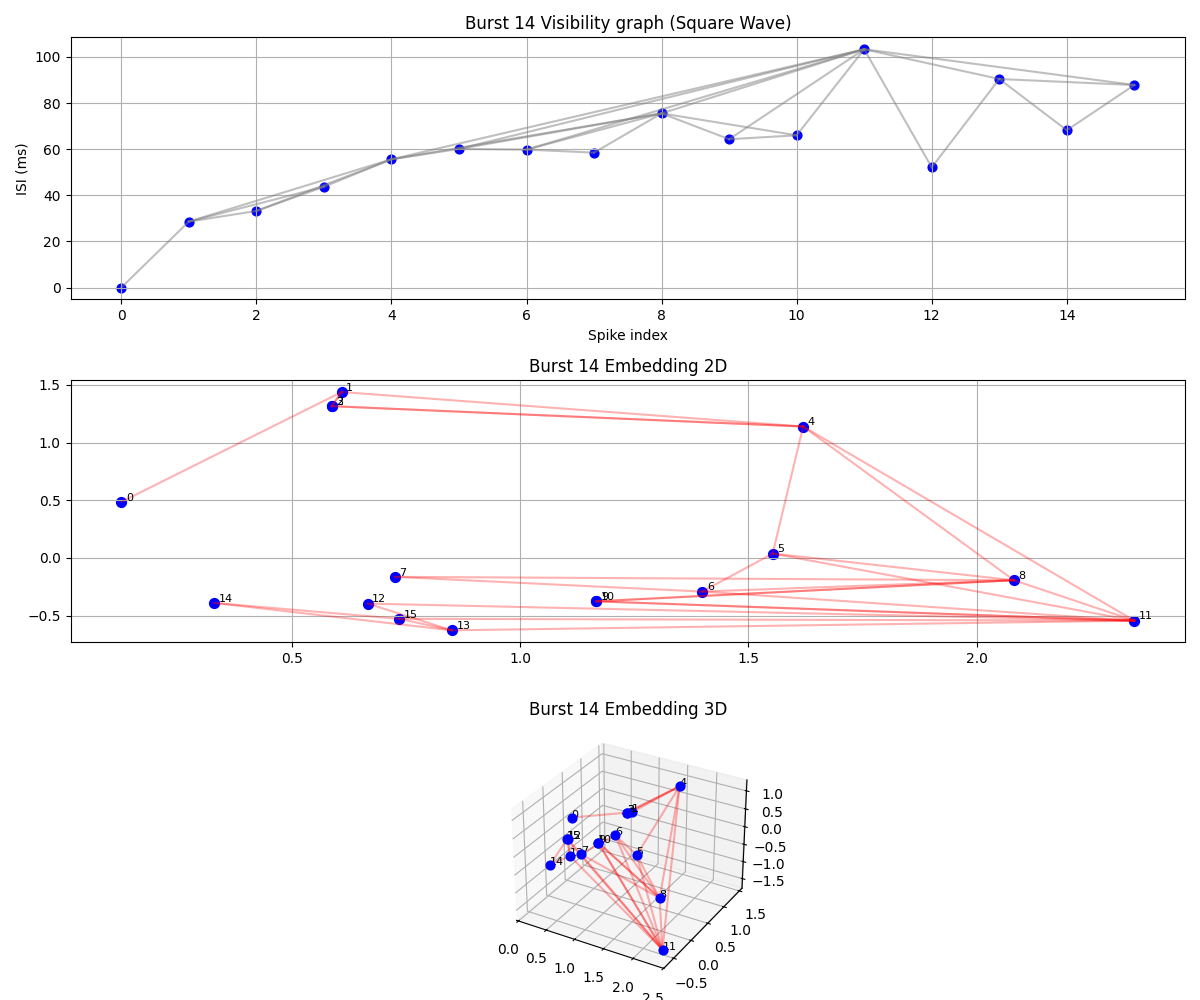

In [3]:
#Load libraries
import pyabf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx #Creates and analyses graphs
from scipy.signal import find_peaks
from sklearn.decomposition import TruncatedSVD #Reduces the dimensionality of matrices (embedding)
%matplotlib widget




#Load the entire ABF
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

#Concatenate all the sweeps
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])#Combines all the sweeps of an ABF into a single continuous voltage vector
dt = 1.0 / abf.dataRate #Time interval between samples (seconds)
time = np.arange(len(signal)) * dt



#Spikes detection
threshold = -35  # mV
spike_indices, _ = find_peaks(signal, height=threshold) #indices in the "signal" array where the spikes occur
spike_times = time[spike_indices]




#Bursts detection
isi = np.diff(spike_times)
burst_threshold = 0.3  # s
bursts = [] #A "bursts" list is constructed where each element is a list of spike indices that form a burst
current_burst = [0]

for i in range(1, len(spike_times)):
    if isi[i-1] < burst_threshold:
        current_burst.append(i)
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst) #Saves the burst
        current_burst = [i] #Restarts the burst
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Se detectaron {len(bursts)} bursts")




#Calculate internal ISI for each burst (ms)
#For each spike within a burst, the internal ISI is calculated in milliseconds
isi_per_spike_burst = np.zeros(len(spike_times)) #A vector of zeros of the same size as "spike_times" is initialized
for burst in bursts:
    for i, idx in enumerate(burst): #"idx" is global index of the spike within the entire signal
        isi_per_spike_burst[idx] = 0 if i==0 else (spike_times[idx]-spike_times[burst[i-1]])*1000 #It is established that the ISI of the first spike of every burst will be 0. I may be wrong about this, but initially I thought it made sense




#Burst Classification
square_wave_bursts, parabolic_bursts, other_bursts = [], [], []
burst_types = {}  #"burst_types" stores the type of each burst.

for i, burst in enumerate(bursts):
    #Extract the portion of the signal corresponding to the current burst
    burst_mask = (time >= spike_times[burst[0]]) & (time <= spike_times[burst[-1]])
    burst_min = np.min(signal[burst_mask])# minimum voltage during the burst

    # Computees mean signal level before and after the burst
    # prev_mean: average signal between the end of the previous burst and the start of the current one
    prev_mean = np.mean(signal[(time > spike_times[bursts[i-1][-1]]) & (time < spike_times[burst[0]])]) if i>0 else np.nan

    # next_mean: average signal between the end of the burst and the start of the next one
    next_mean = np.mean(signal[(time > spike_times[burst[-1]]) & (time < spike_times[bursts[i+1][0]])]) if i<len(bursts)-1 else np.nan

    # inter_mean: mean baseline level around the burst (ignores NaN if first or last burst)
    inter_mean = np.nanmean([prev_mean, next_mean])
    
    # Classification the burst type based on its minimum voltage compared to baseline
    if burst_min > inter_mean:
        square_wave_bursts.append(burst)
        burst_types[tuple(burst)] = "Square Wave"
    elif burst_min < inter_mean:
        parabolic_bursts.append(burst)
        burst_types[tuple(burst)] = "Parabolic"
    else:
        other_bursts.append(burst)
        burst_types[tuple(burst)] = "Other"




#Save bursts related basic info in CSV
burst_list = []

#All bursts are added, without separating them by type, only in chronological order
for idx, burst in enumerate(bursts):
    burst_type = burst_types[tuple(burst)]
    burst_list.append([idx+1, spike_times[burst[0]], spike_times[burst[-1]], burst_type])

#Creating DataFrame with all bursts
df_bursts_all = pd.DataFrame(burst_list, columns=["Burst_Number","Start_Time_s","End_Time_s","Type"])

#Save CSV with all bursts
df_bursts_all.to_csv("burst_basic_info_cell89_all_bursts.csv", index=False)

#Extract first 10 bursts for display
df_bursts_head10 = df_bursts_all.iloc[:10]

print(df_bursts_head10)





#Visibility graph and embeddings
colors_map = {"Square Wave":"blue", "Parabolic":"green", "Other":"orange"} #I have chosen to use different colours for de nodes in the visibility graph, depending on the type of the burst
nodes_list, edges_list = [], []

for b_idx, burst in enumerate(bursts): #Iterate over each burst and its index
    burst_type = burst_types[tuple(burst)] #Get the type of the current burst using its spike pattern as a key
    x_peaks = np.arange(len(burst))
    y_peaks = isi_per_spike_burst[burst]


    #Visibility graph
    G = nx.Graph() #Create a new empty graph for the current burst
    G.add_nodes_from(range(len(burst))) # Add one node per spike in the burst
    for a in range(len(x_peaks)): # Compare all pairs of spikes (a, b) in the burst
        for b in range(a+1, len(x_peaks)):
            visible = True
            for c in range(a+1,b):  # Check all intermediate spikes (c) between a and b
                y_line = y_peaks[b]+(y_peaks[a]-y_peaks[b])*(x_peaks[b]-x_peaks[c])/(x_peaks[b]-x_peaks[a]) # Compute the expected y-value of the straight line connecting (a, y_a) and (b, y_b) at position c
                if y_peaks[c] >= y_line: # If spike c is above or on the line, then visibility is blocked
                    visible=False
                    break
            if visible: 
                G.add_edge(a,b) # If no intermediate spike blocks the view, add an edge (a, b) 
                edges_list.append([b_idx+1, burst_type, a, b])  # Save the edge info: burst index, burst type, node a, node b
    

    #Embeddings
    A = nx.to_numpy_array(G) # Convert the burst's graph into its adjacency matrix
    n_dim = min(3,A.shape[0]) # Define the minimum dimensionality for embedding (There were problems in trying to generate a 3D embedding with some burst with fewer nodes, probably may I have to change something here to make it more accurate)
    embedding_2d = TruncatedSVD(n_components=2, random_state=42).fit_transform(A) # Compute a 2D embedding of the graph adjacency matrix using Truncated SVD
    embedding_3d = TruncatedSVD(n_components=n_dim, random_state=42).fit_transform(A) if n_dim>=3 else np.zeros((len(burst),3)) #Same here nwith the 3D embedding


    #Save nodes with coordinates both in 2D and in 3D (the difference is not that much) and global spike index (because some of the previously detected spikes are out of the bursts, might not be necessary, but I have put it)
    for i in range(len(burst)):
        nodes_list.append([b_idx+1, burst_type, i,
                           embedding_2d[i,0], embedding_2d[i,1],
                           embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2],
                           burst[i]])  # Índice global del spike



    #Plot only the first 10 bursts, just to help to visualize 
    if b_idx < 14:
        fig = plt.figure(figsize=(12,10))

        #Visibility graph
        ax0 = fig.add_subplot(3,1,1)
        for u,v in G.edges():
            ax0.plot([x_peaks[u], x_peaks[v]], [y_peaks[u], y_peaks[v]], 'gray', alpha=0.5)
        ax0.scatter(x_peaks, y_peaks, color=colors_map[burst_type], s=40)
        ax0.set_title(f"Burst {b_idx+1} Visibility graph ({burst_type})")
        ax0.set_xlabel("Spike index")
        ax0.set_ylabel("ISI (ms)")
        ax0.grid(True)

        #Embedding in 2D
        ax1 = fig.add_subplot(3,1,2)
        for i in range(len(burst)):
            ax1.scatter(embedding_2d[i,0], embedding_2d[i,1], color=colors_map[burst_type], s=50)
            ax1.text(embedding_2d[i,0]+0.01, embedding_2d[i,1]+0.01, str(i), fontsize=8)
        for u,v in G.edges():
            ax1.plot([embedding_2d[u,0], embedding_2d[v,0]], [embedding_2d[u,1], embedding_2d[v,1]], 'r-', alpha=0.3)
        ax1.set_title(f"Burst {b_idx+1} Embedding 2D")
        ax1.grid(True)

        #Embedding in 3D
        if embedding_3d is not None:
            ax2 = fig.add_subplot(3,1,3, projection='3d')
            for i in range(len(burst)):
                ax2.scatter(embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2], color=colors_map[burst_type], s=40)
                ax2.text(embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2], str(i), fontsize=8)
            for u,v in G.edges():
                ax2.plot([embedding_3d[u,0], embedding_3d[v,0]],
                         [embedding_3d[u,1], embedding_3d[v,1]],
                         [embedding_3d[u,2], embedding_3d[v,2]], 'r-', alpha=0.3)
            ax2.set_title(f"Burst {b_idx+1} Embedding 3D")

        plt.tight_layout()
        plt.show()



# Save CSV of nodes and edges
df_nodes = pd.DataFrame(nodes_list, columns=["Burst_Number","Type","Node_ID",
                                             "X_2D","Y_2D","X_3D","Y_3D","Z_3D",
                                             "Spike_Global_Index"])
df_edges = pd.DataFrame(edges_list, columns=["Burst_Number","Type","Node1_ID","Node2_ID"])

df_nodes.to_csv("burst_nodes_all.csv", index=False)
df_edges.to_csv("burst_edges_all.csv", index=False)